In [1]:
#Imports
import numpy as np

import math as m
import matplotlib.pyplot as plt
import matplotlib as mpl
import statistics as st
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
mpl.rcParams['figure.dpi'] = 110
mpl.rcParams['figure.dpi'] = 500
mpl.rcParams['font.size'] = 14
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['figure.figsize'] = (6.0, 4.5)
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['savefig.bbox'] = 'tight'


## Kinetic-Diffusion Sulfonation Model

For the reaction of PE with CSA it can be simply represented as:

$$R-[CH_2]_3-R^2 + 2 CSA \rightarrow R-CHSO_2OHCH=CH-R^2$$


The coupled PDE's to be solved for PE and CSA:
\begin{equation}
	\frac{\partial C_{\text{PE}}}{\partial t} = -k_{\text{S-PE}}C_{\text{PE}}C_{\text{CSA}}^2 = r_{\text{PE}}
\end{equation}

\begin{equation}
	\frac{\partial C_{\text{S-PE}}}{\partial t} = k_{\text{S-PE}}C_{\text{PE}}C_{\text{CSA}}^2 = -r_{\text{PE}}
\end{equation}

\begin{equation}
	\begin{split}
		\frac{\partial C_{\text{CSA}}}{\partial t} &= \frac{1}{r^2}\frac{\partial}{\partial r}\left(D_{\text{CSA}}r^2\frac{\partial C_{\text{CSA}}}{\partial r} \right)+2r_{\text{PE}}\\
		&= D_{\text{CSA}}\frac{\partial^2C_{\text{CSA}}}{\partial r^2} + \frac{\partial D_{\text{CSA}}}{\partial r}\times\frac{\partial C_{\text{CSA}}}{\partial r} + \frac{2D_{\text{CSA}}}{r}\frac{\partial C_{\text{CSA}}}{\partial r}+2r_{\text{PE}}
	\end{split}
\end{equation}
where $D_{\text{CSA}} = D_{\text{CSA}o}f$, $f = (1-k*\tilde{C}_{\text{PE}})$, $\frac{\partial D_{\text{CSA}}}{\partial \tilde{r}} = -D_{\text{CSA}o}k\frac{\partial\tilde{C}_{\text{PE}o}}{\partial \tilde{r}}$, $\tilde{C}_{\text{PE}} =\frac{C_{\text{PE}}}{C_{\text{PE}o}}$, $C_{\text{PE}o}$ is the initial PE concentration in the solid, $k_{\text{\text{S-PE}}}$ is the S-PE formation rate constant, and $k$, is a constant representing the resistance of PE to CSA diffusion. As $k\rightarrow 1$ it is expected that CSA diffusion will not occur in PE until CSA has sulfonated PE. In layers where $\tilde{C}_{\text{PE}}\rightarrow 0$, CSA diffusivity is maximized. This key development in CSA flux is based on observations in this work and others (Nazarov et al. 2009), where sulfonating agents penetrated further into PE the more it was sulfonated. Thus, the larger the value of $k$, the more a shrinking core mechanism is expected, since this would result in CSA unable to diffuse into PE until surface layers have been reacted. Additionally, the rate law has a second order dependence on CSA concentration stemming from the two moles of CSA required to sulfonate PE. 

Modeling this system was achieved by non-dimensionalizing the system of PDE's to give the following:
\begin{equation}
	\frac{\partial \tilde{C}_{\text{PE}}}{\partial \tilde{t}} = -\boldsymbol{\mathrm{Da}}\Phi\tilde{C}_{\text{PE}}\tilde{C}_{\text{CSA}}^2
\end{equation}

\begin{equation}
	\frac{\partial \tilde{C}_{\text{S-PE}}}{\partial \tilde{t}} = \boldsymbol{\mathrm{Da}}\Phi\tilde{C}_{\text{PE}}\tilde{C}_{\text{CSA}}^2
\end{equation}

\begin{equation}
	\begin{split}
		\frac{\partial \tilde{C}_{\text{CSA}}}{\partial \tilde{t}} &=\frac{1}{\tilde{r}^2}\frac{\partial}{\partial \tilde{r}}\left(\tilde{r}^2f\frac{\partial \tilde{C}_{\text{CSA}}}{\partial \tilde{r}}\right)-2\boldsymbol{\mathrm{Da}}\tilde{C}_{\text{PE}}\tilde{C}_{\text{CSA}}^2\\		
		&= f\frac{\partial^2\tilde{C}_{\text{CSA}}}{\partial \tilde{r}^2} + \frac{\partial f}{\partial \tilde{r}}\times\frac{\partial \tilde{C}_{\text{CSA}}}{\partial \tilde{r}}+ \frac{2f}{\tilde{r}}\frac{\partial\tilde{C}_{\text{CSA}}}{\partial \tilde{r}}-2\boldsymbol{\mathrm{Da}}\tilde{C}_{\text{PE}}\tilde{C}_{\text{CSA}}^2
	\end{split}
\end{equation}
where the dimensionless concentrations were $\tilde{C}_{\text{PE}} = \frac{C_{\text{PE}}}{C_{\text{PE}o}}$, $\tilde{C}_{\text{S-PE}} = \frac{C_{\text{S-PE}}}{C_{\text{PE}o}}$, and  $\tilde{C}_{\text{CSA}} = \frac{C_{\text{CSA}}}{C_{\text{CSA}o}}$, $\tilde{t} = \frac{tD_{\text{CSA}o}}{R^2}$ is the dimensionless time, $C_{\text{PE}o}$ is the initial concentration of PE in the solid, $C_{\text{CSA}o}$ is the initial concentration of CSA in the liquid, $R$ is the particle radius, $D_{\text{CSA}o}$  is the uninhibited diffusion coefficient of CSA in S-PE, $\tilde{r} = \frac{r}{R}$ is the dimensionless radius, $\boldsymbol{\mathrm{Da}} = \frac{k_{\text{S-PE}}R^2C_{\text{PE}o}C_{\text{CSA}o}}{D_{\text{CSA}o}}$ is the Damköhler number, $\frac{\partial f}{\partial \tilde{r}} = -k\frac{\partial\tilde{C}_{\text{PE}o}}{\partial \tilde{r}}$, and $\Phi = \tilde{C}_{\text{CSA}o}/\tilde{C}_{\text{PE}o}=\frac{\frac{\rho_{\text{CSA}}V_{\text{CSA}}}{MW_{\text{CSA}}V_{acid}}}{\rho_{\text{PE}}/(MW_{\text{CH2}}n_c)}$ is the CSA to PE concentration ratio, and $n_c$ is the number of carbons per sulfonate. Since sulfonation sites generally form a three-carbon $\beta$,$\gamma$-alkene sulfonic acid, it was assumed that each mole of sulfonated PE comprised three carbons, or gave a $n_c$ = 3. The symbols $\rho_i$, $V_i$, and $MW_i$ are the density, volume, and molecular weight of the $i^{th}$ species, respectively. Both $\tilde{t}$ and $\Phi$ can be calculated from our experimental conditions based on initial particle sizes, volume of CSA ($V_{\ch{CSA}}$), and total acid ($V_{\text{Acid}}$) used in our reactions. Due to this, $\Phi$ was related to the mole fraction of CSA, $y_{\text{CSA}}$:
\begin{equation}
	\Phi = \frac{n_c MW_{\text{CH2}}\left( 1- \left(\frac{1-y_{\text{CSA}}}{y_{\text{CSA}}}\right)\left(\frac{MW_{\text{SA}}}{MW_W}\right)\omega_W\right)}{\rho_{PE}\left[\frac{MW{\text{CSA}}}{\rho_{\text{CSA}}} + \frac{(1-y_{\text{CSA}})MW_{\text{SA}}}{y_{\text{CSA}}\rho_{\text{CSA}}}\right]}
\end{equation}
where $\omega_W$ is the mole fraction of water in SA, which consumes CSA by reacting to form SA and HCl. Interestingly, at an $\omega_W = 3-5\%$ for typical concentrated SA when $y_{\text{CSA}} = 17\%$, $\Phi \rightarrow 0$. This would explain why S-PE materials synthesized at $y_{\text{CSA}} = 17\%$ had little to no observed sulfonation.

Another term observed naturally throughout the numerical calculations was the PE to total acid volume ratio ($V_R$). This term can be completely represented with the only unknowns being $y_{\text{CSA}}$ and the CSA to carbon molar ratio ($\Theta_{\text{CSA}}$):

\begin{equation}
	V_R = \frac{V_{\text{PE}}}{V_{\text{Acid}}} = \frac{MW_{\text{CH2}}}{\rho_{\text{PE}}\Theta_{\text{CSA}}\left[\frac{MW_{\text{CSA}}}{\rho_{\text{CSA}}} + \frac{(1-y_{\text{CSA}})MW_{\text{SA}}}{y_{\text{CSA}}\rho_{\text{SA}}}\right]}
\end{equation}
Thus, for numerical solutions it became only necessary to vary $k$, $\boldsymbol{\mathrm{Da}}$, $y_{\text{CSA}}$, and $\Theta_{\text{CSA}}$.
However, due to the consumption of CSA, the volume of acid in the liquid will decrease with time. This will result in the concentration of CSA at the liquid boundary to maintain higher concentrations for longer times, and should therefore result in greater reaction rates. Consequently, it becomes important to alter $V_R$ to the following:
\begin{equation}
	V_R = \frac{V_{\text{PE}}}{V_{\text{Acid}}} = \frac{1}{V_{R,\text{SA}} + V_{R,\text{CSA}}} 
\end{equation}
where $V_{R,\text{SA}} = \frac{V_{\text{SA}}}{V_{\text{PE}}} = \Theta_{\text{CSA}}\left(\frac{1-y_{\text{CSA}}}{y_{\text{CSA}}}\right)\left(\frac{\rho_{\text{PE}}}{\rho_{\text{SA}}}\right)\left(\frac{MW_{\text{SA}}}{MW_{\text{CH2}}}\right)$ is the volume of SA to PE ratio, and $V_{R,\text{CSA}} = \frac{V_{\text{CSA}}}{V_{\text{PE}}} = \Theta_{\text{CSA}}\left(\frac{\rho_{\text{PE}}}{\rho_{\text{CSA}}}\right)\left(\frac{MW_{\text{CSA}}}{MW_{\text{CH2}}}\right)$ is the volume of CSA to PE ratio. For $V_{R,\text{SA}}$, it is only necessary to compute the initial value since the volume of PE and SA is assumed constant. Conversely, $V_{R,\text{CSA}}$ will change with time and is implemented as a time dependent boundary condition coupled with CSA at the solid-liquid interface.

* $\tilde{r} \in \left[0,1\right]$
* $\tilde{t} \in \left[0,5\right]$
* BC @ $\tilde{r} \in \left[0,1 \right)$ and $\tilde{t} = 0$:
	
	* $\tilde{C}_{\text{CSA}} = 0$, $\tilde{C}_{\text{PE}} = 1$, and $\tilde{C}_{\text{S-PE}} = 0$
	
* BC @ $\tilde{r}>1$ and $\tilde{t} = 0$: 
	
	* $\tilde{C}_{\text{CSA}} = 1$, $\tilde{C}_{\text{PE}} = 0$, and $\tilde{C}_{\text{S-PE}} = 0$
	
* BC @ $\tilde{r} =  1$  and $\tilde{t}> 0$:
	
		
	1. $\left. \frac{\partial \tilde{C}_{\text{CSA}}}{\partial\tilde{t}}\right|_{F,i =1/\Delta\tilde{r}} = \frac{3f\left[ \nu_{\text{CSA}}\tilde{C}_{\text{CSA}} -1\right]}{V_{R,\text{SA}} + V_{R,\text{CSA}}}\left. \frac{\partial\tilde{C}_{\text{CSA}}}{\partial\tilde{r}}\right|_{F,i =1/\Delta\tilde{r}}\\
		\approx \frac{3f\left[ \nu_{\text{CSA}}\tilde{C}_{\text{CSA}} -1\right]}{V_{R,\text{SA}} + V_{R,\text{CSA}}}\frac{\tilde{C}_{\text{CSA},i =1/\Delta\tilde{r}-2}^F-4\tilde{C}_{\text{CSA},i =1/\Delta\tilde{r}-1}^F+ 3\tilde{C}_{\text{CSA},i =1/\Delta\tilde{r}}^F}{2\Delta\tilde{r}}$
	2. $\left. \frac{\partial\tilde{C}_{\text{PE}}}{\partial\tilde{t}}\right|_{F,i =1/\Delta\tilde{r}}  = -\boldsymbol{\mathrm{Da}}\Phi\tilde{C}_{\text{PE},i =1/\Delta\tilde{r}}^{F}(\tilde{C}_{\text{CSA},i =1/\Delta\tilde{r}}^{F})^2$
	3.  $\left. \frac{\partial\tilde{C}_{\text{S-PE}}}{\partial\tilde{t}}\right|_{F,i =1/\Delta\tilde{r}} =\boldsymbol{\mathrm{Da}}\Phi\tilde{C}_{\text{PE},i =1/\Delta\tilde{r}}^{F}(\tilde{C}_{\text{CSA},i =1/\Delta\tilde{r}}^{F})^2$
	4. $\left. \frac{\partial V_{R,\text{CSA}}}{\partial\tilde{t}}\right|_{F,i =1/\Delta\tilde{r}} = -\frac{3f\nu_{CSA}}{V_{R,\text{SA}} + V_{R,\text{CSA}}}\left. \frac{\partial\tilde{C}_{\text{CSA}}}{\partial\tilde{r}}\right|_{F,i =1/\Delta\tilde{r}}$
	
* BC @ $\tilde{r} = 0$ and $\tilde{t}>0$:
	
	1. $\left. \frac{\partial\tilde{C}_{\text{PE}}}{\partial\tilde{t}}\right|_{F,i=0} = \left(4\left. \frac{\partial\tilde{C}_{\text{PE}}}{\partial\tilde{t}}\right|_{F,i=1}-\left. \frac{\partial\tilde{C}_{\text{PE}}}{\partial\tilde{t}}\right|_{F,i=2}\right)/3$
	2. $\left. \frac{\partial\tilde{C}_{\text{S-PE}}}{\partial\tilde{t}}\right|_{F,i=0} = \left(4\left. \frac{\partial\tilde{C}_{\text{S-PE}}}{\partial\tilde{t}}\right|_{F,i=1}-\left. \frac{\partial\tilde{C}_{\text{S-PE}}}{\partial\tilde{t}}\right|_{F,i=2}\right)/3$
	3. $\left. \frac{\partial\tilde{C}_{\text{CSA}}}{\partial\tilde{t}}\right|_{F,i=0} = \left(4\left. \frac{\partial\tilde{C}_{\text{CSA}}}{\partial\tilde{t}}\right|_{F,i=1}-\left. \frac{\partial\tilde{C}_{\text{CSA}}}{\partial\tilde{t}}\right|_{F,i=2}\right)/3$
	

where $F$ is the current frame in time, $i$ is the $i^{th}$ position in space, the radius at position $i$, $\tilde{r}_i =\Delta\tilde{r}\times i$, and $\nu_{\text{CSA}} = \frac{\frac{y_{\text{CSA}}MW_{\text{CSA}}}{\rho_{\text{CSA}}}}{\frac{y_{\text{CSA}}MW_{\text{CSA}}}{\rho_{\text{CSA}}} + \frac{(1-y_{\text{CSA}})MW_{\text{SA}}}{\rho_{\text{SA}}}}$ is the initial volume fraction of CSA in the liquid. The time derivatives of PE, CSA, and S-PE for $\tilde{r} \in \left(0,1\right)$ were described as:
\begin{equation}
	\left. \frac{\partial\tilde{C}_{\text{PE}}}{\partial\tilde{t}}\right|_{F,i} = -\boldsymbol{\mathrm{Da}}\Phi\tilde{C}_{\text{PE},i}^{F}(\tilde{C}_{\text{CSA},i}^{F})^2
\end{equation}

\begin{equation}
	\begin{split}
		\left. \frac{\partial\tilde{C}_{\text{CSA}}}{\partial\tilde{t}}\right|_{F,i}&= \frac{f}{\Delta\tilde{r}^2}\left[\tilde{C}_{\text{CSA},i+1}^{F} - 2\tilde{C}_{\text{CSA},i}^{F} + \tilde{C}_{\text{CSA},i-1}^{F} \right]\\
		&+ \frac{1}{4\Delta\tilde{r}^2}\frac{\partial f}{\partial C_{\text{PE}}}\times(\tilde{C}_{\text{CSA},i+1}^{F}-\tilde{C}_{\text{CSA},i-1}^{F})\times(\tilde{C}_{\text{PE},i+1}^{F}-\tilde{C}_{\text{PE},i-1}^{F})\\
		&+ \frac{f}{\tilde{r}_i\Delta\tilde{r}}\left(\tilde{C}_{\text{CSA},i+1}^{F} - \tilde{C}_{\text{CSA},i-1}^{F} \right)- 2\boldsymbol{\mathrm{Da}}\tilde{C}_{\text{PE},i}^{F}(\tilde{C}_{\text{CSA},i}^{F})^2
	\end{split}
\end{equation}

\begin{equation}
	\left. \frac{\partial\tilde{C}_{\text{S-PE}}}{\partial\tilde{t}}\right|_{F,i}= \boldsymbol{\mathrm{Da}}\Phi\tilde{C}_{\text{PE},i}^{F}(\tilde{C}_{\text{CSA},i}^{F})^2
\end{equation}

The way in which the kinetic-diffusion sulfonation model was solved at varying positions in time. Since each discrete layer comprised a volume, $\Delta V = 4\pi r^2\Delta r$, any information such as total concentration or conversions must account for the changing volume in each layer. For example, the conversion of PE and CSA can be represented as follows:
\begin{equation}
	X_{\text{PE}}^F = 1 - \frac{\sum_{i=1}^{1/\Delta\tilde{r}}\tilde{C}_{\text{PE},i}^Fi^2}{\sum_{i=1}^{1/\Delta\tilde{r}}i^2}
\end{equation}

\begin{equation}
	X_{\text{CSA}}^F = 1 - \tilde{C}_{\text{CSA},\tilde{r}>1}^F(V_R^0/V_R^F)- 3\sum_{i=1}^{1/\Delta\tilde{r}}\tilde{C}_{\text{CSA},i}^Fi^2V_R^0\Delta\tilde{r}^3
\end{equation}
where $V_R^0$ is the initial PE to total acid volume ratio and $V_R^F$ is the PE to total acid volume ratio in frame $F$.

In [6]:
def dcdt(t,c, params):
    ''''Function that solves the PDE's and returns a solved matrix at each 
        position (pixel) and point in time (frame)

       Args:
          k: PE resistance to CSA
          Da: Damkholer number
          phi: CSA to PE cocnentration ratio
          V_R: PE to total acid volume ratio
          dr: Step size in radial-direction
          r_inv: Inverse radius
          p: Number of pixels to solve over p
          volp: CSA volume percent
     
      Returns:
            array-like: Differential equations of Cpe, Ccsa, and V_IR
    '''
    k,Da,phi_0,V_R,dr,r_inv,p,volp = params

    V_RI0 = 1/V_R
    

    #split equations into PE, CSA, and Volume equations
    c_pe = c[:int(p+1)]
    c_csa =  c[int(p+1):-1]
    V_RI = c[-1]

    #PE finite difference terms
    C_pe_i = c_pe[1:-1] 
    C_pe_im1 = c_pe[:-2]
    C_pe_ip1 = c_pe[2:]
     
    #CSA finite difference terms
    C_csa_i = c_csa[1:-1]
    C_csa_im1 = c_csa[:-2]
    C_csa_ip1 = c_csa[2:]
    
    #Initialize differential equations
    dc_pedt = np.zeros(len(c_pe))
    dc_csadt = np.zeros(len(c_csa))
    
    f = 1-k*C_pe_i
    df = -k #-k*f
    f2 = 1-k*c_pe[-1]
    #PE balance r<=1
    dc_pedt[1:-1] = -Da*phi_0*c_pe[1:-1]*c_csa[1:-1]**2

    #csa balance at r <1 using central difference for first derivatives
    dc_csadt1 = (1/dr**2)*(C_csa_ip1 - 2*C_csa_i + C_csa_im1)*(f)
    dc_csadt2 = df*(C_pe_ip1-C_pe_im1)*(C_csa_ip1-C_csa_im1)*(1/(4*dr**2))
    dc_csadt3 = 2*f*(C_csa_ip1-C_csa_im1)*(1/(2*dr))*r_inv[:-1]
    dc_csadt4 = (2)*Da*C_pe_i*C_csa_i**2
    dc_csadt[1:-1] = dc_csadt1 + dc_csadt2 +  dc_csadt3 - dc_csadt4
    
    #BC's at r = 0
    dc_pedt[0] = (4*dc_pedt[1] - dc_pedt[2])/3
    dc_csadt[0] = (4*dc_csadt[1] - dc_csadt[2])/3

    #BC r=1
    #Change in concentration of CSA in liquid boundary
    a = (2*dr*(V_RI + V_RI0*(1-volp/100)))
    b = (c_csa[-1]*volp/100-1)
    dc_csadt[-1] = 3*f2*(c_csa[-3]-4*c_csa[-2]+3*c_csa[-1])/a*b
    #V_IR balance (V_IR = V_CSA/V_PE)
    dV_IRdt = -3*f2*(c_csa[-3]-4*c_csa[-2]+3*c_csa[-1])/(2*dr)*(volp/100)
    dc_pedt[-1] =  -Da*phi_0*c_pe[-1]*c_csa[-1]**2
    r = np.array([dc_pedt, dc_csadt]).ravel()
    return np.append(r,dV_IRdt,axis = None)

def solvePDE(k,Da,volp,v_acid):
    ''''Function that solves PDE's in dcdt using solve_ivp. )

     Args:
          k: PE resistance to CSA
          Da: Damkholer number
          volp: CSA volume percent
          v_acid: Initial Volume of acid per gram of PE
  
      Returns:
          c_pe (array): Dimensionless concentration of PE
          c_csa (array): Dimensionless concentration of CSA
          x_pe (array): PE conversion
          x_csa (array): CSA conversion
          ycsa: Initial CSA mole fraction
          theta_csa: Initial CSA to carbon molar ratio
          phi: CSA to PE cocnentration ratio
          V_R: PE to total acid volume ratio
          V_csa (array): Volume of CSA
    '''
    #Normalized radius
    r_n = 1

    #finite step size in radial-direction
    dr = 0.001

    #Number of pixels to solve over p
    p = r_n/dr

    #pe density
    rho_pe = 0.96

    #CSA mole fraction
    ycsa = y_csa(volp)

    #theta_csa
    thet_csa = theta_csa(v_acid,ycsa)

    #PE to total acid Volume Ratio
    V_R = VR(ycsa,thet_csa)

    #Total acid to PE volume ratio
    V_IR0 = 1/V_R
    #phi
    phi_0 = phi(volp)

   

    #radial position 1 to 1/dr
    r_vec = np.arange(1,1/dr+1,1)*dr
    #Squared radius
    r_sq = r_vec**2
    #Inverse radius
    r_inv = 1/r_vec

    
    #Parameters
    params = k,Da,phi_0,V_R,dr,r_inv,p,volp

    #Time evaluations
    t_span = [0,5]
    t_eval = np.linspace(0,5,2500)

    #Initial conditions
    pe_ic = np.linspace(1,1,int(p+1))
    csa_ic = np.linspace(0,0,int(p+1))
    csa_ic[-1] = 1
    v_ir_csa_ic = v_acid*(volp/100)*(rho_pe/1)
    y0 = np.array([pe_ic,csa_ic])
    y1 = y0.ravel()
    y1 = np.append(y1,v_ir_csa_ic, axis = None)

    #Solve differential equations using solve_ivp
    sol = solve_ivp(dcdt, t_span, y1, args=(params,),dense_output=True, method = 'Radau')
    sol0 = sol.sol(t_eval)
    
    #pe concentration
    c_pe = sol0[:int(p+1)]

    #csa concentration
    c_csa = sol0[int(p+1):-1]

    #CSA to PE volume ratio
    V_IR = sol0[-1]

    #Volume of csa
    V_csa = V_IR*1/rho_pe

    #Time dependent PE to total acid volume ratio.
    V_R2 = 1/(V_IR0*(1-volp/100) +V_IR)

    x_pe = []
    x_csa = []
    #Conversion calculation
    for i in range(len(c_pe[0])):
        x_pe.append(1- sum(c_pe[1:,i]*r_sq)/sum(r_sq))
        x_csa.append(1 - c_csa[-1,i]*(V_R/V_R2[i])*(1-3*V_R*dr*r_sq[-1]) - 3*sum(c_csa[1:,i]*r_sq)*V_R*dr )
        
    
    return c_pe,c_csa,np.array(x_pe)*100, np.array(x_csa)*100, ycsa, thet_csa, phi_0, V_R2, V_csa


def phi(volp):
    '''Function calculates the concentration ratio of CSA to PE (Phi)'''
    ycsa = y_csa(volp) 

    #densities (g/ml)  
    rho_csa = 1.75
    rho_sa = 1.83
    rho_pe = 0.96

    #molecular weights (g/mole)
    mw_csa = 116.52
    mw_sa = 98.08
    mw_w = 18
    mw_ch2 = 14

    #mass fraction of water in sulfuric acid
    w_w = 0.05

    #moles of carbon per sulfonation reaction
    nc = 3

    a = mw_csa/rho_csa + ((1-ycsa)*mw_sa/(ycsa*rho_sa))
    return (1-((1-ycsa)/ycsa)*(mw_sa/mw_w)*w_w)*(nc*mw_ch2/rho_pe)/(a)


def VR(ycsa,theta_csa):
    '''Function calculates the Volume ratio of PE to CSA (V_R)'''
    #densities (g/ml)
    rho_csa = 1.75
    rho_sa = 1.83
    rho_pe = 0.96

    #molecular weights (g/mole)
    mw_csa = 116.52
    mw_sa = 98.08
   
    mw_ch2 = 14
    return (mw_ch2)/(rho_pe*theta_csa*(mw_csa/rho_csa + ((1-ycsa)*mw_sa/(ycsa*rho_sa))))
def theta_csa(v_acid,ycsa):

    #densities (g/ml)
    rho_csa = 1.75
    rho_sa = 1.83

    #molecular weights (g/mole)
    mw_csa = 116.52
    mw_sa = 98.08
    mw_ch2 = 14

    return (v_acid*mw_ch2)/(mw_csa/rho_csa + ((1-ycsa)/(ycsa*rho_sa))*mw_sa)
def y_csa(volp):
    '''Takes in volume percent CSA for samples and converts to mole fraction'''
    '''Returns mole fraction of CSA in SA'''

    #densities (g/ml)
    rho_CSA = 1.75 
    rho_SA = 1.83 
    
    #molecular weights (g/mole)
    MW_CSA = 116.52
    MW_SA = 98.079
    
    return (((rho_CSA*(volp/100))/MW_CSA)/(((rho_CSA*(volp/100))/MW_CSA)+ (1-(volp/100))*(rho_SA/MW_SA)))
def param(volp, vol):
    '''Takes in volume percent and volume of acid for samples and converts to molar ratio and mole fraction'''
    '''Returns mole fraction and molar ratio of CSA to carbon'''

    #densities (g/ml)
    rho_CSA = 1.75 
    rho_SA = 1.83 
    
    #molecular weights (g/mole)
    MW_CSA = 116.52
    MW_SA = 98.079
    MW_ch2 = 14.03

    n_ch2 = 1/MW_ch2

    ycsa = (((rho_CSA*(volp/100))/MW_CSA)/(((rho_CSA*(volp/100))/MW_CSA)+ (1-(volp/100))*(rho_SA/MW_SA)))
    theta_csa = ((rho_CSA*(vol*volp/100))/MW_CSA)/n_ch2
    return ycsa, theta_csa

def X_find(t,X, t_r):

    '''Function to find conversion (X) at dimensionless time t_r'''

    count = 0
    while t[count] < t_r:
        count += 1
    return t[count], X[count]

def c_find(t,c, t_r):

    '''Function to find concentration at dimensionless time t_r'''

    count = 0
    while t[count] < t_r:
        count += 1
    return t[count], c[count]

def L2_norm(c1,c2,r1,r2):
    c = []
    c20 = []
    for i in range(1,len(c1[0])):
        
        c.append((sum(c1[:,i]*r1)/sum(r1)-sum(c2[:,0]*r2)/sum(r2)))
        c20.append(sum(c2[:,i]*r2)/sum(r2))
    return np.sqrt(sum(c)**2/sum(c20)**2)
 

In [22]:
Da_plot = [15.20238036,15.20238036,2.92711149,2.92711149]
k_plot = [0.98, 0, 0.98, 0]
volp = 50
v_acid0 = 10
c_pe1,c_csa1,x_pe1, x_csa1, ycsa1, thet_csa1, phi_01, V_R1, V_acid1 = solvePDE(k_plot[0],Da_plot[0],volp, v_acid0)
print(1)
c_pe2,c_csa2,x_pe2, x_csa2, ycsa2, thet_csa2, phi_02, V_R2, V_acid2 = solvePDE(k_plot[1],Da_plot[1],volp,v_acid0)
print(2)
#c_pe3,c_csa3,x_pe3, x_csa3, ycsa3, thet_csa3, phi_03, V_R3, V_acid3 = solvePDE(k_plot[2],Da_plot[2],volp,v_acid0,0)
#print(3)
#c_pe4,c_csa4,x_pe4, x_csa4, ycsa4, thet_csa4, phi_04, V_R4, V_acid4 = solvePDE(k_plot[3],Da_plot[3],volp,v_acid0,0)
#print(4)


1
2


In [24]:
c_pe_plot = [c_pe1,c_pe2]
c_spe_plot = [1-c_pe1,1-c_pe2]
c_csa_plot = [c_csa1,c_csa2]
ycsa_plot = [ycsa1,ycsa2]
thet_csa_plot = [thet_csa1,thet_csa2]
c_csa_plot = [c_csa1,c_csa2]

phi_plot = [phi_01,phi_02]
VR_plot = [V_R1,V_R2]
dr = 0.001
r_vec = np.arange(0,1/dr+1,1)*dr
r_vec2 = np.append(r_vec,np.linspace(1+dr,1+ (int(0.2*len(r_vec))-1)*dr,int(0.2*len(r_vec))-1), axis=None)
t_eval = np.linspace(0,5,2500)
print(r_vec2)

[0.000e+00 1.000e-03 2.000e-03 ... 1.197e+00 1.198e+00 1.199e+00]


In [25]:

c_pe_plot2 = [[] for i in range(len(c_pe_plot))]
c_csa_plot2 = [[] for i in range(len(c_csa_plot))]

for i in range(len(t_eval)):
    for j in range(len(c_pe_plot2)):
        c_pe0 = c_pe_plot[j][:,i]
        c_peij = c_pe0#np.append(c_spe_plot[j][:,i],np.linspace(c_spe0,c_spe0,int(0.2*len(r_vec))-1), axis=None)
        c_pe_plot2[j].append(c_peij.tolist())
        
        c_csa0 = c_csa_plot[j][-1,i]
        c_csaij = np.append(c_csa_plot[j][:,i],np.linspace(c_csa0,c_csa0,int(0.2*len(r_vec))-1), axis=None)
        c_csa_plot2[j].append(c_csaij.tolist())




### PE and CSA Concentration Profiles Over Time

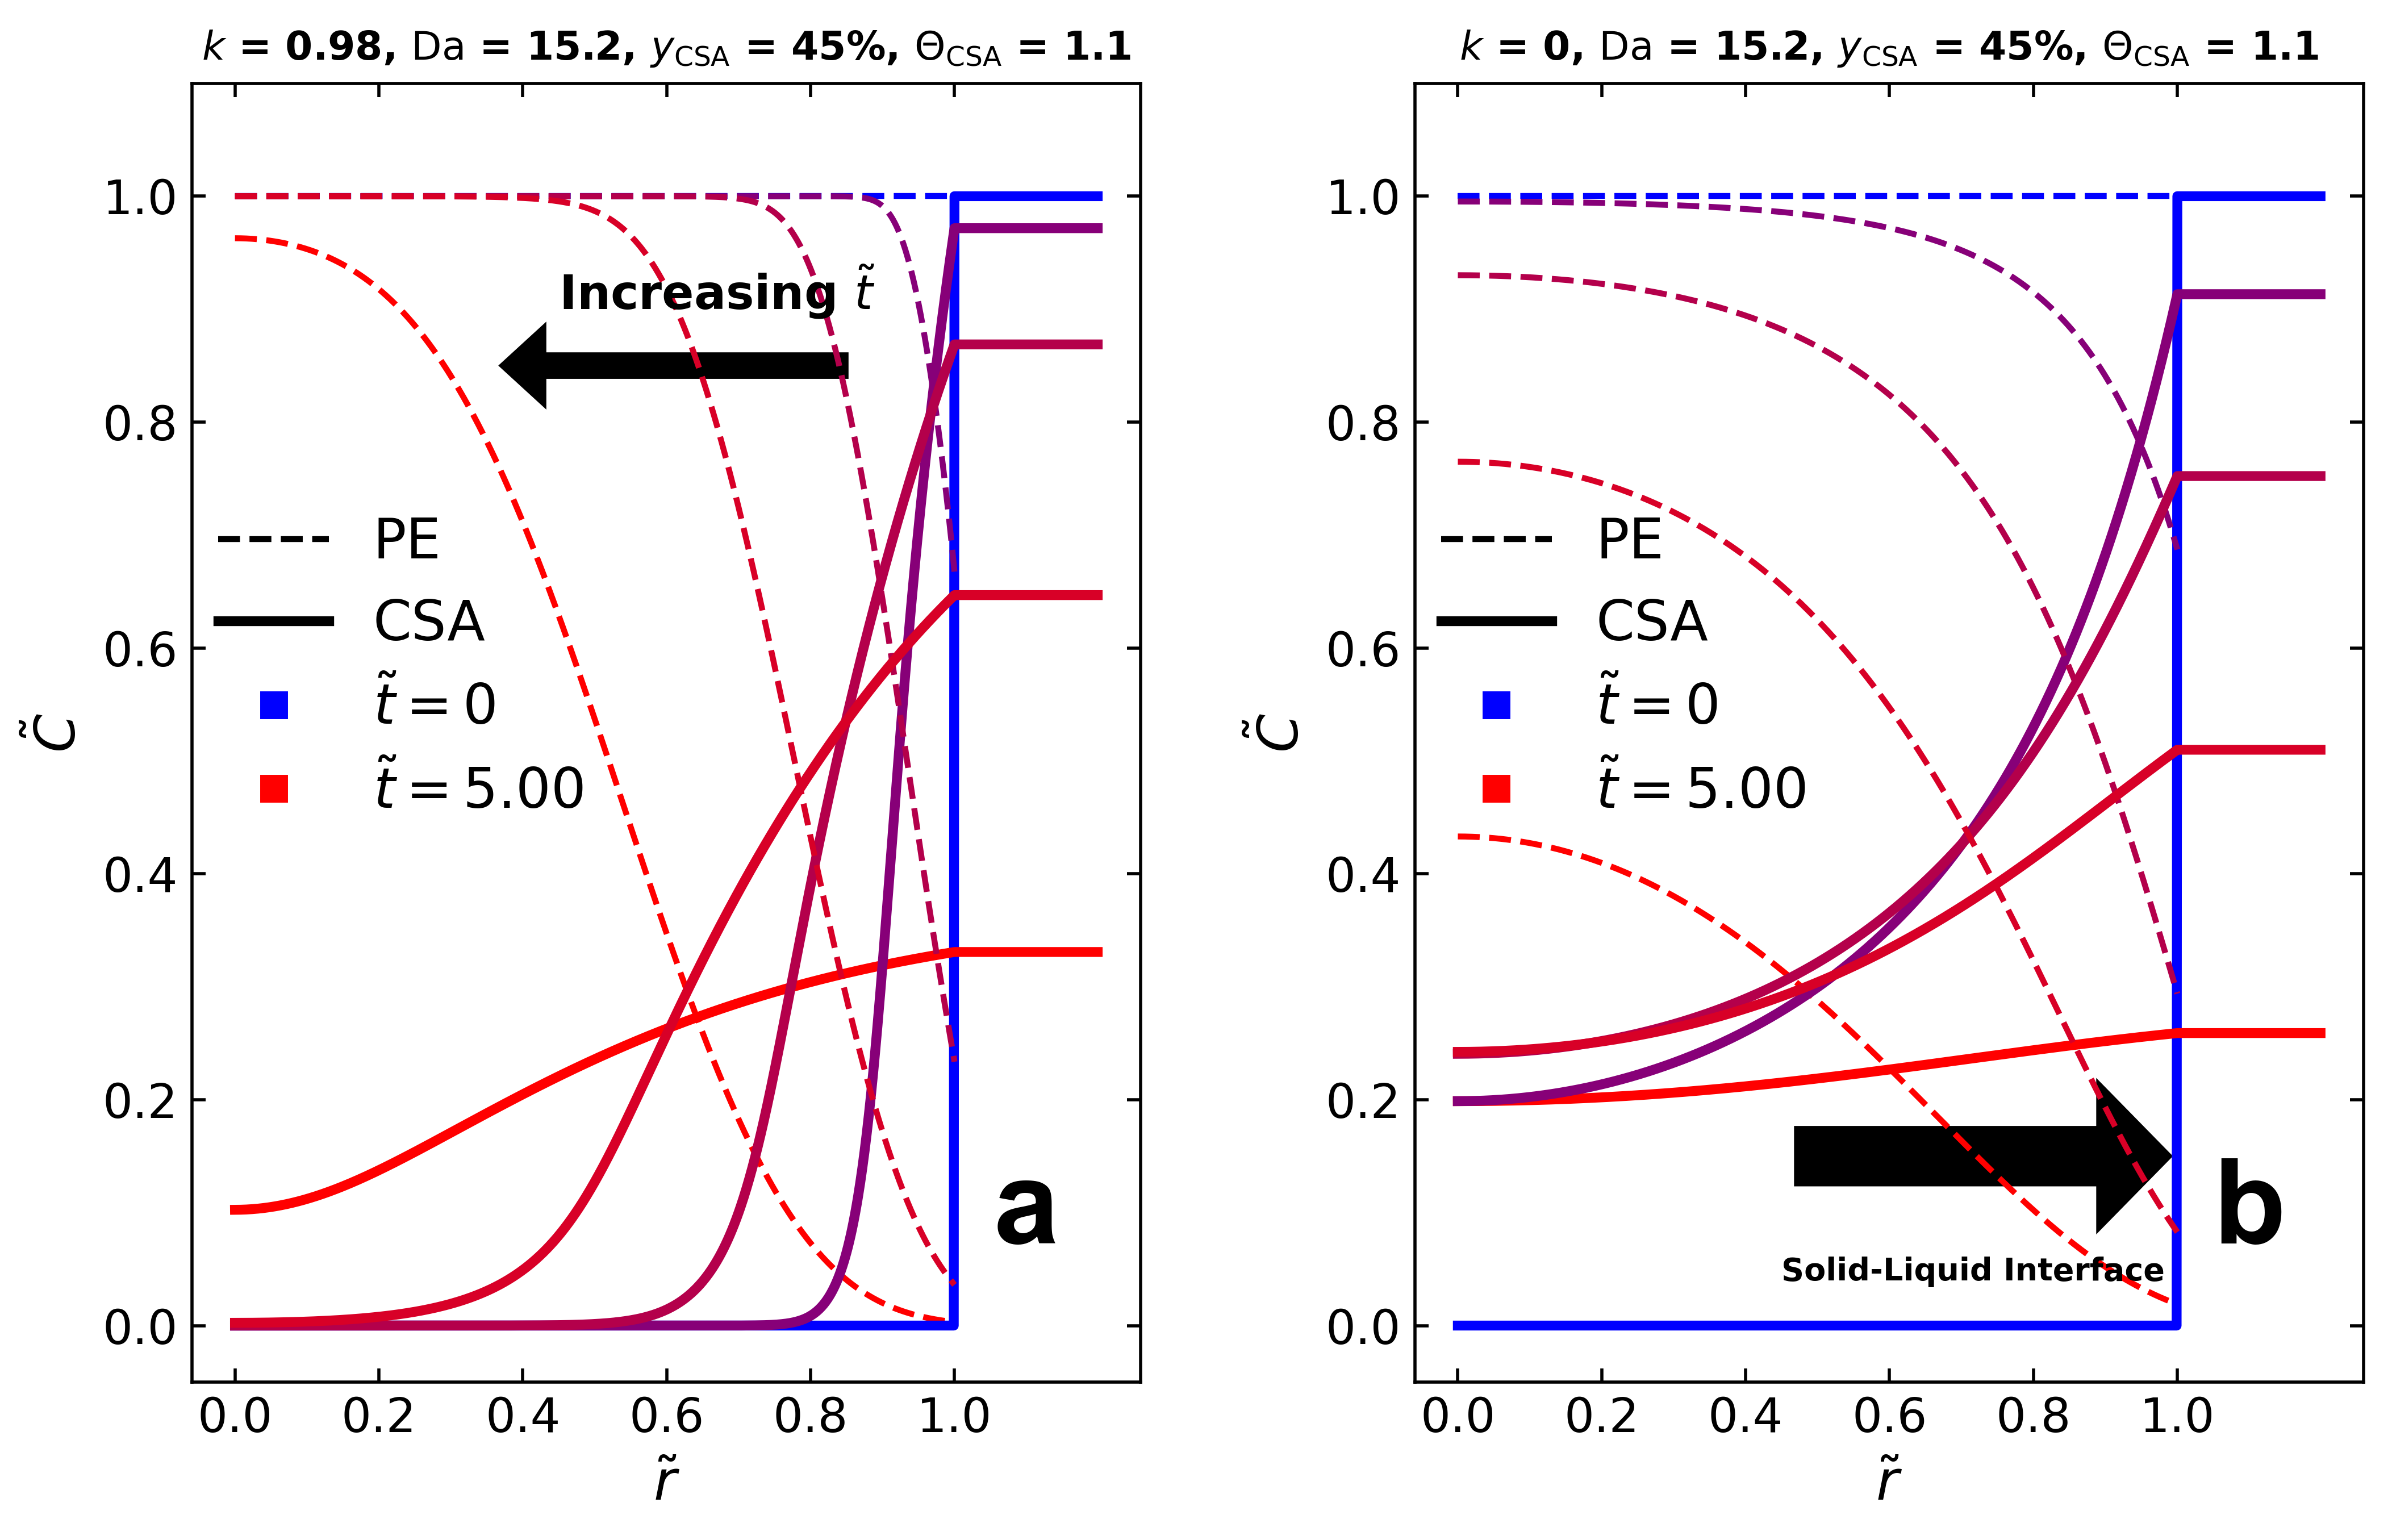

In [26]:
col = 2
row = 1
#Fraes in simulation to be plotted for each axis
frame_plot = [[0,63,250,750,2499],
              [0,63,250,750,2499],
              [0,63,750,2499],
              [0,3, 5,13,25, 63,2499]]
fig,ax =plt.subplots(row, col, figsize = (9, 6))
ax = ax.ravel()

fig.subplots_adjust(hspace = .20, wspace=0.2)
labels = ['a', 'b', ' c', 'd']


x_tick_locations = [0.0,0.2,0.4,0.6,0.8,1.0]
y_tick_locations = [0.0,0.2,0.4,0.6,0.8,1.0]
for i in range(len(ax)):
    params = r'$k$ = ' + str(k_plot[i]) + r', $\mathrm{Da}$ = ' 
    + str(round(Da_plot[i],2)) + r', $y_{\rm CSA}$ = ' 
    + str(round(ycsa_plot[i]*100)) + r'%, $\Theta_{\rm CSA}$ = ' 
    + str(round(thet_csa_plot[i],1))

    ax[i].plot([],[], '--',color = 'black' , label = r'PE' )
    ax[i].plot([],[], '-',color = 'black' , label = r'CSA',linewidth = 2.5)
    ax[i].plot([],[],'s',color = 'blue' , label = r'$\tilde{t} = $' + str(round(0)) )
    ax[i].plot([],[],'s',color = 'red' , label = r'$\tilde{t} = $' 
               + '{:.2f}'.format(t_eval[frame_plot[i][-1]]) )
    ax[i].plot(r_vec,c_pe_plot2[i][0], '--',color = (0,0,1))
    ax[i].plot(r_vec,c_pe_plot2[i][frame_plot[i][-1]], '--',color = 'red')
    ax[i].plot(r_vec2,c_csa_plot2[i][0], '-',color = (0,0,1), linewidth = 2.5)
    ax[i].plot(r_vec2,c_csa_plot2[i][frame_plot[i][-1]], '-',color = 'red', linewidth = 2.5)
    ax[i].set_title(params, weight ="bold", fontsize = "10")
    
    for j in range(1,len(frame_plot[i])-1):
        
    
            colors = (1*((np.log(frame_plot[i][j])/np.log(frame_plot[i][-1]))),
                      0,
                      1-1*((np.log(frame_plot[i][j])/np.log(frame_plot[i][-1]))))
         
            ax[i].plot(r_vec,c_pe_plot2[i][frame_plot[i][j]], '--',color = colors)
            ax[i].plot(r_vec2,c_csa_plot2[i][frame_plot[i][j]], '-',color = colors, linewidth = 2.5)
    
   
    ax[i].set_yticks(y_tick_locations,fontsize = 12, labels = [0.0,0.2,0.4,0.6,0.8,1.0] )
    ax[i].set_xticks(x_tick_locations,fontsize = 12, labels = [0.0,0.2,0.4,0.6,0.8,1.0] )
    ax[i].set_xlabel(r'$\tilde{r}$')
    ax[i].set_ylabel(r'$\tilde{C}$')
    ax[i].set_ylim(-0.05,1.1)
    #[x.set_linewidth(1.5) for x in ax[i].spines.values()]
    ax[i].legend(frameon = False, fontsize = 14,loc = 'center', bbox_to_anchor=(0.22, 0.55)) 
    ax[i].tick_params(axis='both', which='minor')
    ax[i].text(1.1,0.1, labels[i], color = 'black', ha='center', 
               va='center',fontsize = 30, fontname='Arial',weight='bold')

ax[1].text(0.45,0.04, 'Solid-Liquid Interface',fontweight = 'bold', color = 'black', fontsize = 8)
ax[1].arrow(0.47,0.15, 0.42,0, head_width=0.13, head_length = 0.1, width=0.05, color = 'black')
ax[0].arrow(0.85,0.85, -0.42,0, head_width=0.07, head_length = 0.06, width=0.02, color = 'black')
ax[0].text(0.45,0.9, r'Increasing $\tilde{t}$',fontweight = 'bold', color = 'black', fontsize = 12)
plt.tight_layout(pad = 2)
plt.show()


### Volume of CSA ($V_{CSA}$) vs $\tilde{t}$

[5.         4.98839638 4.98290539 ... 0.99145815 0.99113388 0.99080983]


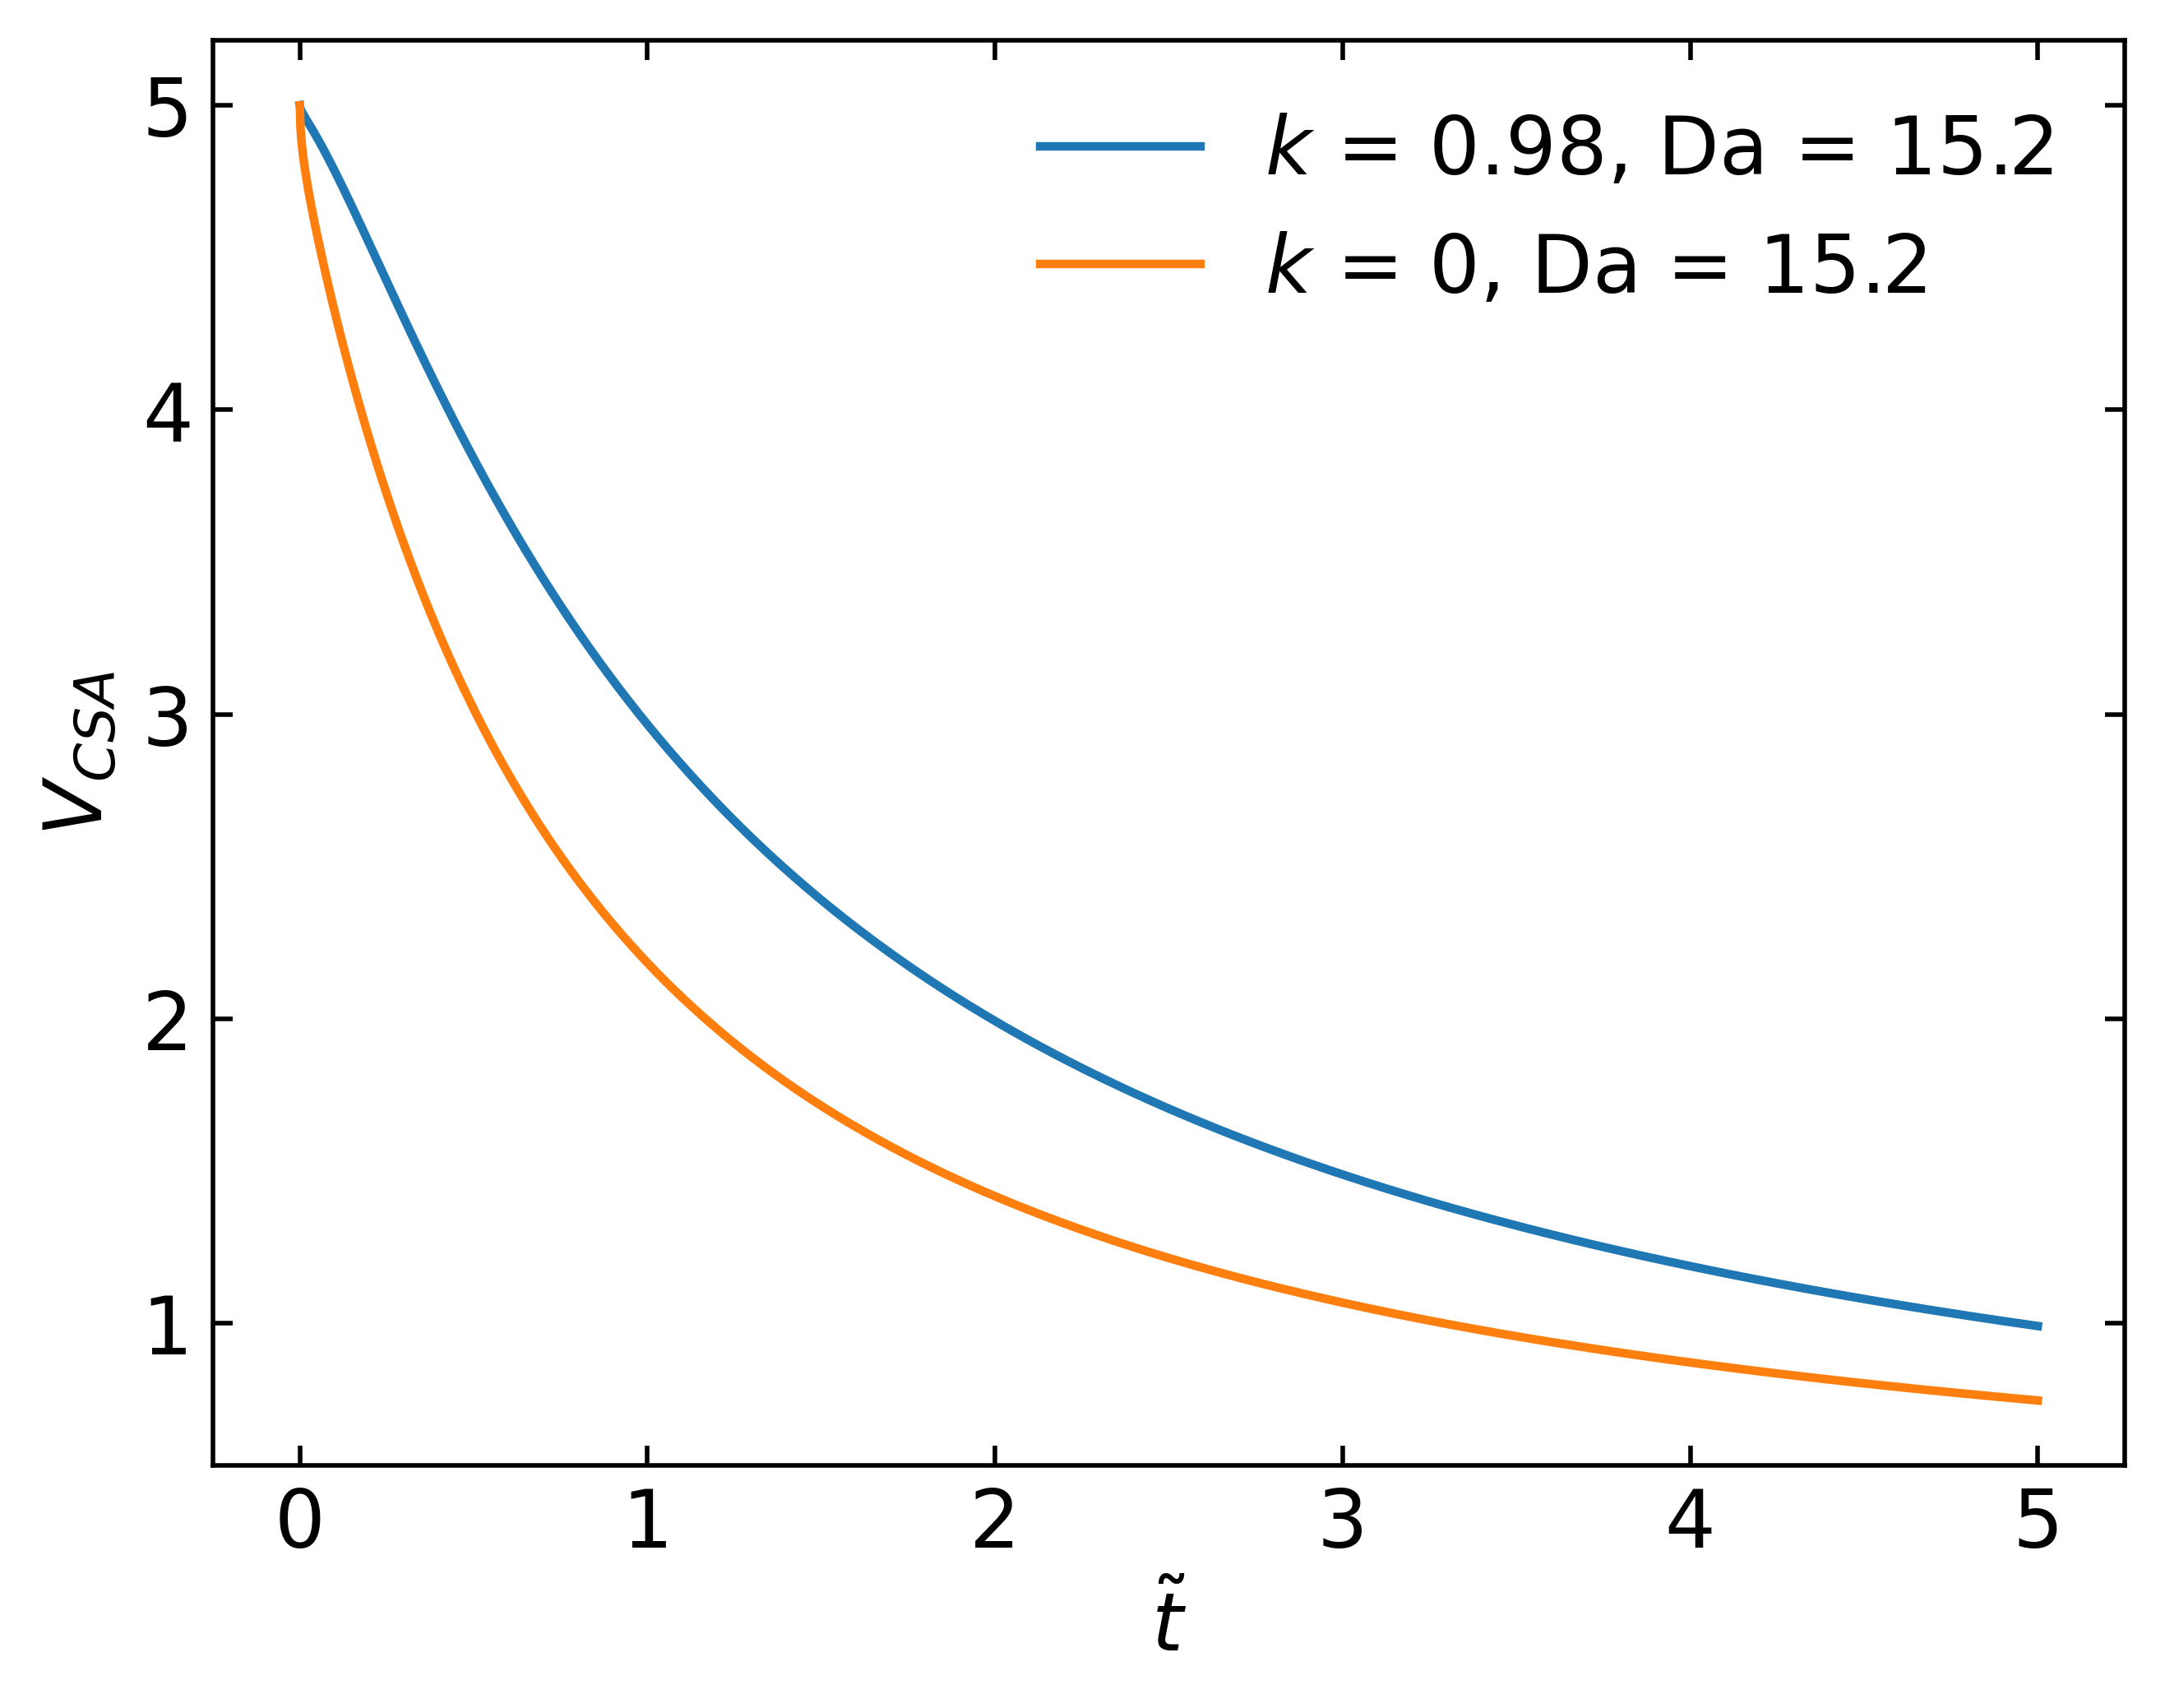

In [27]:

print(V_acid1)
V_acid_vec = [V_acid1, V_acid2]
for i in range(len(V_acid_vec)):
    plt.plot(t_eval, V_acid_vec[i], 
             label = r'$k$ = ' + str(k_plot[i]) + r', $\mathrm{Da}$ = ' 
             + str(round(Da_plot[i],2)))

plt.xlabel(r'$\tilde{t}$')
plt.ylabel(r'$V_{CSA}$')   
plt.legend(frameon = False)
plt.show()

In [12]:
#Solving PDES when sulfonating small particles (decreases Da and increase dimensionless time by a factor of 4)
c_pe5,c_csa5,x_pe5, x_csa5, ycsa5, thet_csa5, phi_05, V_R5, V_acid5 = solvePDE(k_plot[0],Da_plot[0]/4,volp, v_acid0)

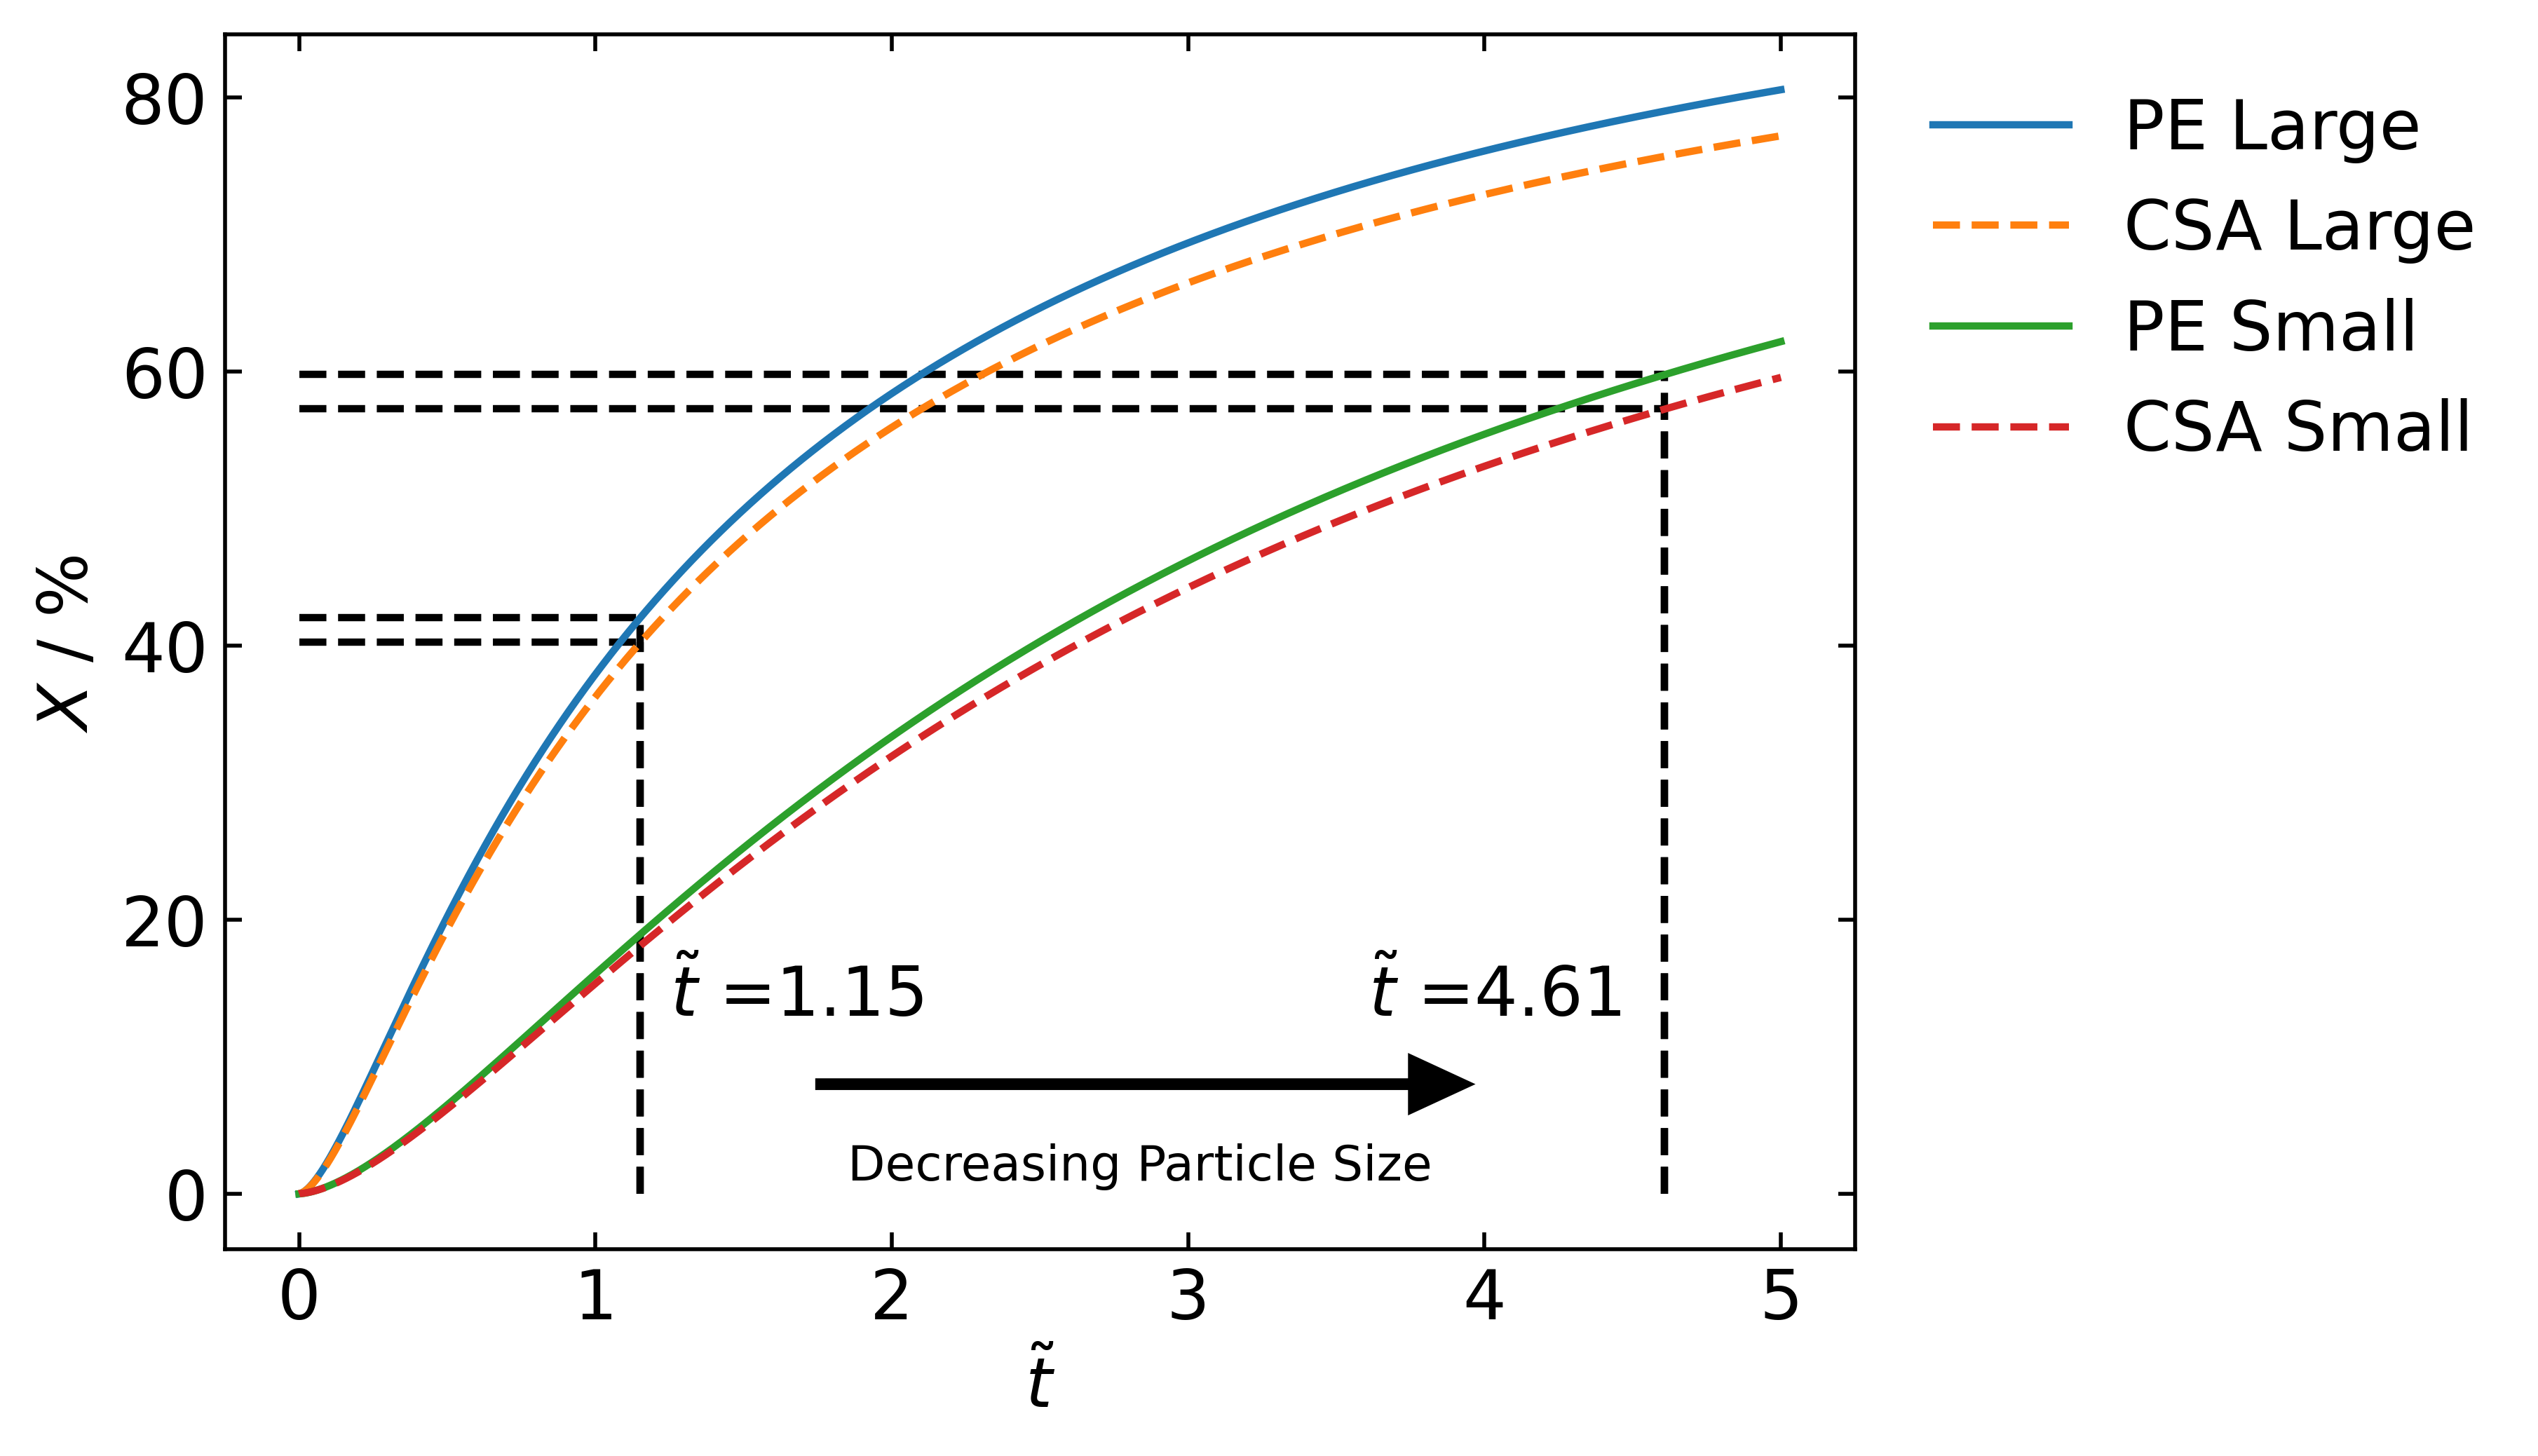

In [13]:
t1,X_pe1 = X_find(t_eval, x_pe1, 1.152)
t1, X_csa1 = X_find(t_eval, x_csa1, 1.152)
t2,X_pe2 = X_find(t_eval, x_pe5, 4.608)
t2,X_csa2 = X_find(t_eval, x_csa5, 4.608)
t11 = [0, 1.152]
t21 = [0,4.608]
t12 = [1.152,1.152]
t22 = [4.608,4.608]



plt.plot(t11, [X_pe1,X_pe1], '--', color = 'black')
plt.plot(t11, [X_csa1,X_csa1], '--', color = 'black')
plt.plot(t12, [0,X_pe1], '--', color = 'black')
plt.plot(t12, [0,X_csa1], '--', color = 'black')

plt.plot(t21, [X_pe2,X_pe2 ], '--', color = 'black')
plt.plot(t21, [X_csa2,X_csa2 ], '--', color = 'black')
plt.plot(t22, [0,X_pe2], '--', color = 'black')
plt.plot(t22, [0,X_csa2 ], '--', color = 'black')
plt.text(t1+0.1,13, r'$\~{t}$ =' + str(round(t1,2)))
plt.text(t2-1,13, r'$\~{t}$ =' + str(round(t2,2)))
plt.text(1.85,1, r'Decreasing Particle Size', size = 10)
plt.arrow(1.75,8, 2,0, head_width=4, head_length = 0.2, width=0.5, color = 'black')
#print(max(Xpe_plot2), max(Xcsa_plot2))
plt.plot(t_eval, x_pe1, '-', label = 'PE Large')
plt.plot(t_eval, x_csa1, '--', label = 'CSA Large')
plt.plot(t_eval, x_pe5, '-', label = 'PE Small')
plt.plot(t_eval, x_csa5, '--', label = 'CSA Small')
plt.xlabel(r'$\~{t}$')
#plt.xlim(-0.1,5.1)
plt.ylabel(r'$X$ / % ')
plt.legend(frameon = False, bbox_to_anchor = [1.01,1])
plt.show()

In [17]:
#print(X_find(t_eval, x_pe1, 1.152), X_find(t_eval, x_csa1, 1.152))
#print(X_find(t_eval, x_pe5, 4.608), X_find(t_eval, x_csa5, 4.608))

print(2*V_R1*X_pe1/phi_01,X_csa1,2*V_R5*X_pe2/phi_05, X_csa2)
print((2*V_R1*X_pe1/phi_01-X_csa1)/X_csa1*100, (2*V_R5*X_pe2/phi_05- X_csa2)/X_csa2*100)

[40.30913233 40.35595985 40.37815723 ... 67.27766653 67.28130797
 67.28494722] 40.24213537804406 [57.29868112 57.3628086  57.39044071 ... 84.4715445  84.47802785
 84.48450826] 57.261077407339066
[ 0.1664846   0.282849    0.33800854 ... 67.18214851 67.19119732
 67.2002407 ] [ 0.06567064  0.17766204  0.22591838 ... 47.52000544 47.53132787
 47.54264518]
